In [1]:
import warnings
warnings.simplefilter('ignore')

import datetime
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Load Dataset

In [2]:
data = pd.read_csv('/Users/kexinluo/Desktop/DS_take_home/11.user_referral_data/referral.csv', parse_dates=['date'])
data.head()

,user_id,date,country,money_spent,is_referral,device_id
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97341 entries, 0 to 97340
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      97341 non-null  int64         
 1   date         97341 non-null  datetime64[ns]
 2   country      97341 non-null  object        
 3   money_spent  97341 non-null  int64         
 4   is_referral  97341 non-null  int64         
 5   device_id    97341 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 4.5+ MB


In [4]:
print('Unique country:\t', len(data['country'].unique()))
print(f"Unique user id: {len(data['user_id'].unique())}")
print('Unique device:\t', len(data['device_id'].unique()))

Unique country:	 9
Unique user id: 18809
Unique device:	 17887


In [5]:
dt_referral_starts = datetime.datetime(2015,10,31)
(pd.Series(data.date.unique()) >= dt_referral_starts).value_counts()

False    28
True     28
dtype: int64

There are 28 days before the program, and 28 days after the program. User Referral program starts right in the middle

In [6]:
# extract day of week information
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)
data.head()

,user_id,date,country,money_spent,is_referral,device_id,dayofweek
0,2,2015-10-03,FR,65,0,EVDCJTZMVMJDG,5
1,3,2015-10-03,CA,54,0,WUBZFTVKXGQQX,5
2,6,2015-10-03,FR,35,0,CBAPCJRTFNUJG,5
3,7,2015-10-03,UK,73,0,PRGXJZAJKMXRH,5
4,7,2015-10-03,MX,35,0,PRGXJZAJKMXRH,5


# Data Visualization

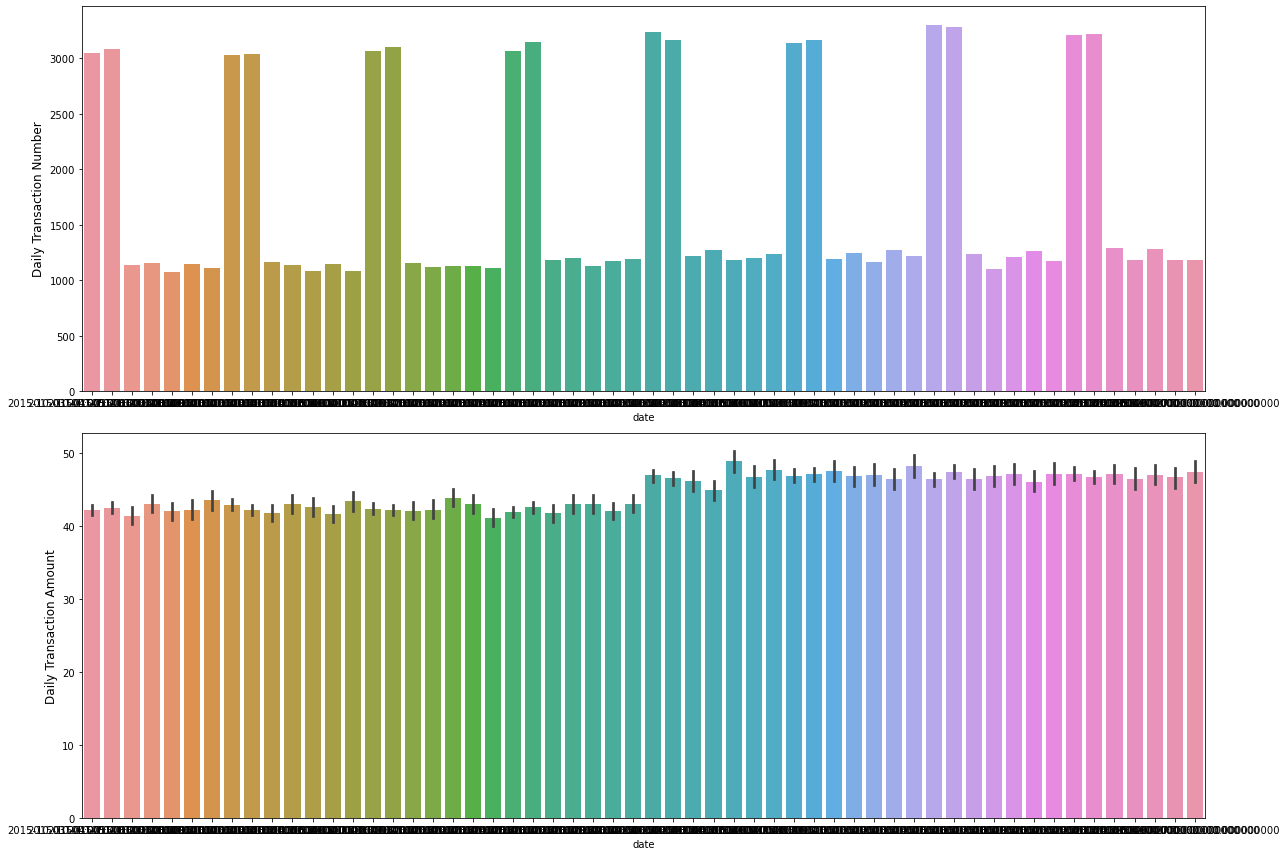

In [7]:
# daily money spent visualization
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='date', data=data, ax=ax[0])
ax[0].set_ylabel('Daily Transaction Number', fontsize=12)

sns.barplot(x='date', y='money_spent', data=data, ax=ax[1])
ax[1].set_ylabel('Daily Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

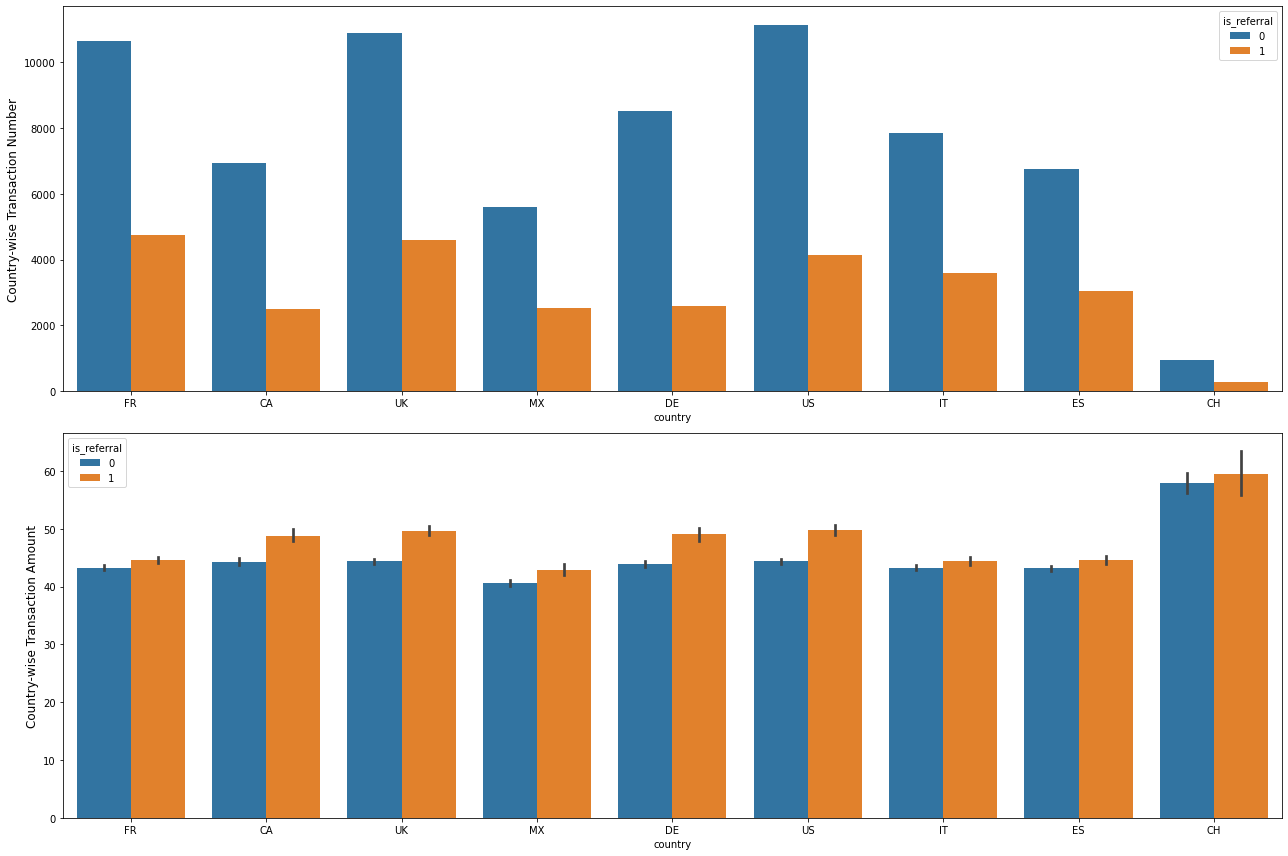

In [8]:
# referral spent visualization
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='country', hue='is_referral', data=data, ax=ax[0])
ax[0].set_ylabel('Country-wise Transaction Number', fontsize=12)

sns.barplot(x='country', y='money_spent', hue='is_referral', data=data, ax=ax[1])
ax[1].set_ylabel('Country-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

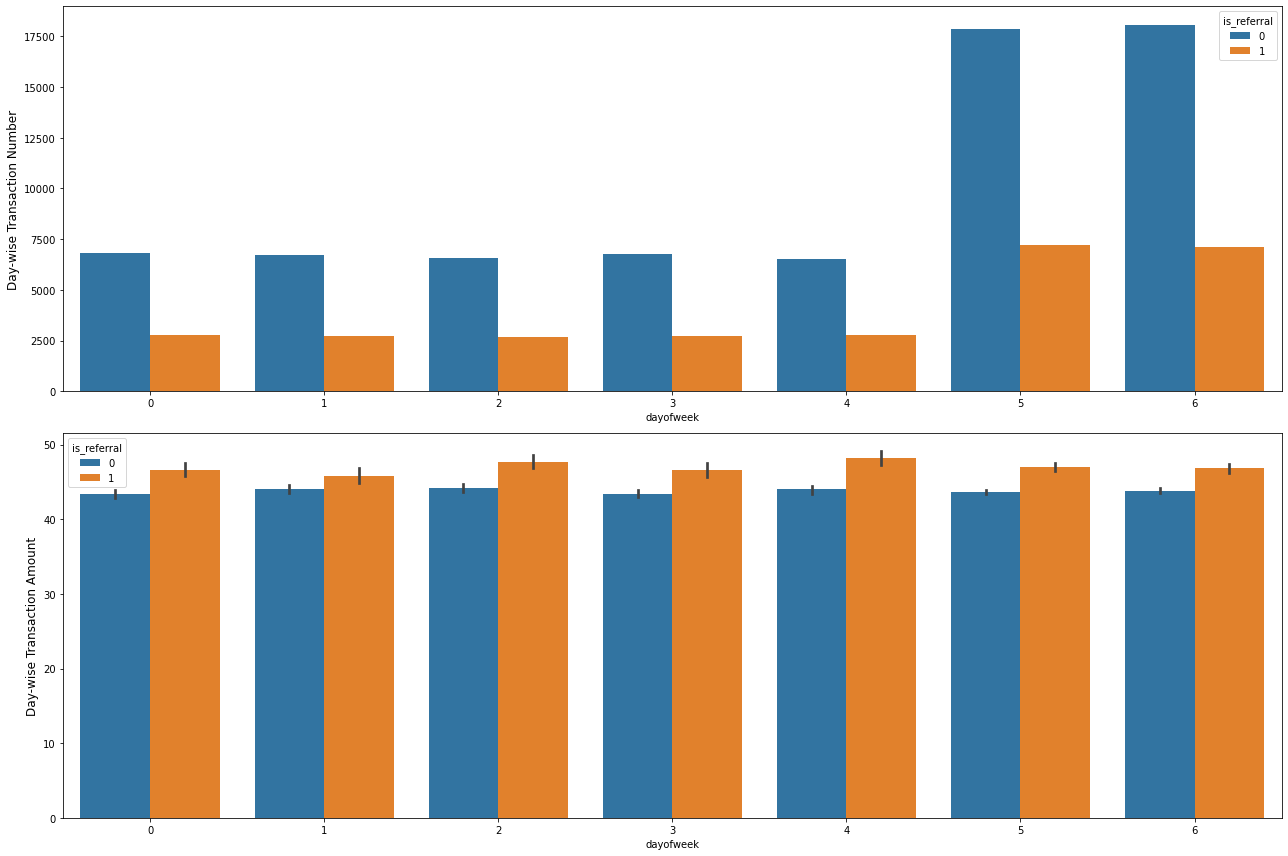

In [9]:
# day of week spent visualization (Monday is 0 and Sunday is 6)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
sns.countplot(x='dayofweek', hue='is_referral', data=data, ax=ax[0])
ax[0].set_ylabel('Day-wise Transaction Number', fontsize=12)

sns.barplot(x='dayofweek', y='money_spent', hue='is_referral', data=data, ax=ax[1])
ax[1].set_ylabel('Day-wise Transaction Amount', fontsize=12)
plt.tight_layout()
plt.show()

# Data Analysis

## 1. Daily Analysis

Use hypothesis test to see if reference (before the referral program dropped) daily statistics differ from new (after the referral program dropped) daily statistics.
- Use T-test to compare two list of values.
- Use two-sided test to see if the before/after statistics are different.

In [10]:
def basic_stat(df):
    """ function to calculate statistics """
    no_purchase = len(df)
    money_spent = df['money_spent'].sum()
    unique_user = len(df['user_id'].unique())
    
    return pd.Series([no_purchase, money_spent, unique_user], 
                     index=['no_purchase', 'money_spent', 'unique_user'])

In [22]:
def daily_stat(data):
    grouped = data.groupby('date').apply(basic_stat).reset_index()
    ref = grouped[grouped['date'] < dt_referral_starts]
    new = grouped[grouped['date'] >= dt_referral_starts]
    
    names = ['no_purchase', 'money_spent', 'unique_user']
    p_vals = []
    ref_vals = []
    new_vals = []
    for name in names:
        a = ref[name].values
        b = new[name].values
        # use two-sided test
        p_val = ttest_ind(a, b, equal_var=False)[1]
        p_vals.append(p_val)
        ref_vals.append(np.mean(a))
        new_vals.append(np.mean(b))
    df = {'ref_mean': np.round(ref_vals,3), 'new_mean': np.round(new_vals), 'p-value': p_vals}
    return pd.DataFrame(df, index=names)

In [23]:
daily_stat(data)

,ref_mean,new_mean,p-value
no_purchase,1690.750,1786.0,0.696514
money_spent,71657.000,83714.0,0.270388
unique_user,1384.464,1687.0,0.119091


No significant difference before/after the referral program regarding number of prchases, money spent and number of users.

## 2. Country-wise Analysis

In [25]:
data.groupby('country').apply(daily_stat)

ref_mean  new_mean   p-value
country                                           
CA      no_purchase    177.143     160.0  0.467970
        money_spent   7468.429    7880.0  0.703409
        unique_user    173.286     159.0  0.536511
CH      no_purchase     26.821      17.0  0.006145
        money_spent   1536.321    1024.0  0.013882
        unique_user     26.714      17.0  0.006285
DE      no_purchase    232.143     164.0  0.023596
        money_spent   9856.750    8014.0  0.162919
        unique_user    224.964     163.0  0.031330
ES      no_purchase    156.607     194.0  0.145276
        money_spent   6648.643    8661.0  0.075043
        unique_user    153.393     193.0  0.115907
FR      no_purchase    244.143     306.0  0.117991
        money_spent  10385.250   13635.0  0.063686
        unique_user    236.500     303.0  0.082247
IT      no_purchase    180.857     228.0  0.114909
        money_spent   7651.571   10193.0  0.051460
        unique_user    176.536     226.0  0.087821
MX      no_purchase    126.464     164.0  0.064861
        money_spent   4975.464    7033.0  0.019340
        unique_user    124.393     163.0  0.052406
UK      no_purchase    264.286     289.0  0.522367
        money_spent  11213.536   14196.0  0.096980
        unique_user    255.571     286.0  0.408796
US      no_purchase    282.286     263.0  0.615601
        money_spent  11921.036   13077.0  0.497749
        unique_user    273.179     261.0  0.737720

From above result, we know 'User Referral' program has different effect in different countries. The program boosts the sales in some country, but in some other countries, it even decrease the sales.